In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

pd.set_option("display.max_colwidth", 150)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sofiapetrova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("train 2.csv")

df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [5]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

### Exploratory Data Analysis

In [8]:
sent_count = df["sentiment"].value_counts()

sent_count

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

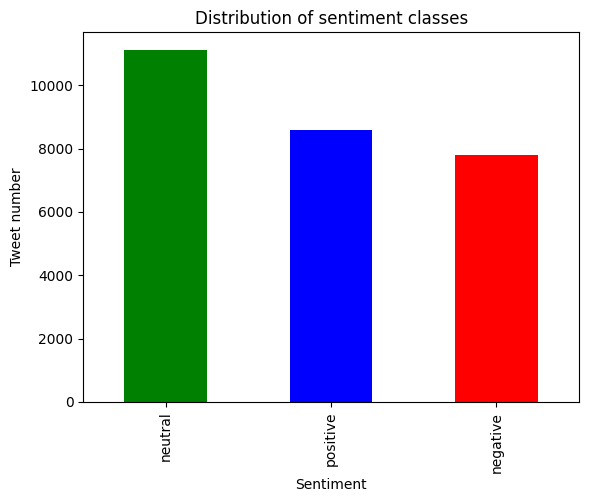

In [9]:
sent_count.plot(kind="bar", color=["green", "blue", "red"])
plt.title("Distribution of sentiment classes")
plt.xlabel("Sentiment")
plt.ylabel("Tweet number")
plt.show()

**The neutral class appears most frequently; the data is slightly imbalanced, so the classifier may tend to predict the neutral sentiment more often.**

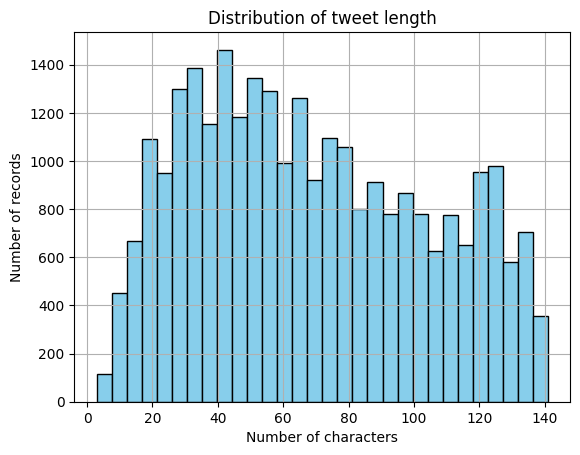

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64

In [10]:
df["text_length"] = df["text"].apply(len)
df["text_length"].hist(bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of tweet length")
plt.xlabel("Number of characters")
plt.ylabel("Number of records")
plt.show()

df["text_length"].describe()

**Most messages are short (30–70 characters), which is typical for Twitter. The average tweet length is about 68 characters. 50% of tweets are shorter than 64 characters, and 75% are shorter than 97 characters.
There is no need for complex processing of long sequences.**

### Text preprocessing and vectorization using bag-of-words

In [11]:
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

def preprocess_text(text):
    text = text.lower()                              
    text = re.sub(r'[^a-z\s]', '', text)             
    tokens = text.split()                          
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(preprocess_text)
df[["text", "clean_text"]].head()

,text,clean_text
0,"I`d have responded, if I were going",id respond go
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego
2,my boss is bullying me...,boss bulli
3,what interview! leave me alone,interview leav alon
4,"Sons of ****, why couldn`t they put them on the releases we already bought",son couldnt put releas alreadi bought


In [12]:
cv_full = CountVectorizer()
X_full = cv_full.fit_transform(df["clean_text"])

words = cv_full.get_feature_names_out()
word_counts = X_full.sum(axis=0).A1  
freq_df = pd.DataFrame({"word": words, "count": word_counts}).sort_values("count", ascending=False)
print("Unique words in total:", len(freq_df))
freq_df.head()

Unique words in total: 22746


,word,count
10105,im,3059
4470,day,2414
7366,go,2363
7190,get,1909
7425,good,1569


In [13]:
freq_df["count"].describe()

count    22746.000000
mean         8.633430
std         58.143549
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       3059.000000
Name: count, dtype: float64

**Most words appear only 1–2 times, meaning they provide almost no useful information for the classifier but add noise to the model.**

In [14]:
freq_df["cum_sum"] = freq_df["count"].cumsum()
freq_df["coverage"] = freq_df["cum_sum"] / freq_df["count"].sum()

freq_df.head(20)

,word,count,cum_sum,coverage
10105,im,3059,3059,0.015577
4470,day,2414,5473,0.027870
7366,go,2363,7836,0.039903
7190,get,1909,9745,0.049624
7425,good,1569,11314,0.057614
22049,work,1483,12797,0.065166
12071,love,1458,14255,0.072590
11745,like,1454,15709,0.079995
5124,dont,1202,16911,0.086115
19939,today,1115,18026,0.091793


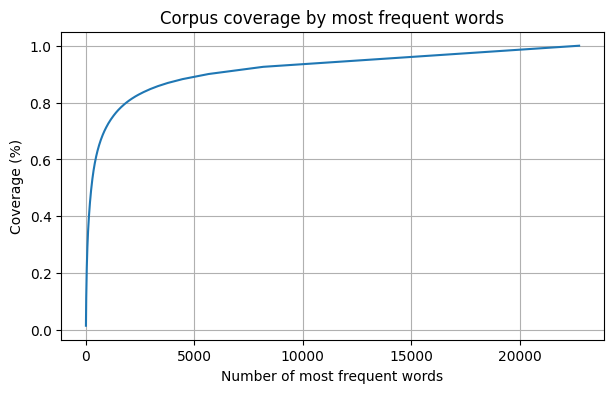

In [15]:
plt.figure(figsize=(7,4))
plt.plot(range(1, len(freq_df)+1), freq_df["coverage"])
plt.title("Corpus coverage by most frequent words")
plt.xlabel("Number of most frequent words")
plt.ylabel("Coverage (%)")
plt.grid(True)
plt.show()

**5,000 words appears to be the most optimal choice.**

In [16]:
vectorizer_bow = CountVectorizer(max_features=5000)
X_bow = vectorizer_bow.fit_transform(df["clean_text"])
X_bow.shape

(27480, 5000)

### Building a classifier

In [17]:
enc = OrdinalEncoder()
df["sentiment_encoded"] = enc.fit_transform(df[["sentiment"]])

y = df["sentiment_encoded"]

X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

print("Size X_train:", X_train_bow.shape)
print("Size X_test:", X_test_bow.shape)

Size X_train: (21984, 5000)
Size X_test: (5496, 5000)


In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}


results = []

for name, model in models.items():
    print(f"\n Model trained: {name}")
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    print(f"Accuracy = {acc:.4f}")


results_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values("Accuracy", ascending=False)
print("\n Accuracy comparison:")
display(results_df)


best_model_name = results_df.iloc[0, 0]
best_model = models[best_model_name]
print(f"\n Best model: {best_model_name}\n")

y_pred_best = best_model.predict(X_test_bow)
print(classification_report(y_test, y_pred_best, target_names=enc.categories_[0]))


 Model trained: Logistic Regression
Accuracy = 0.6889

 Model trained: Decision Tree
Accuracy = 0.6275

 Model trained: Random Forest
Accuracy = 0.6890

 Model trained: XGBoost
Accuracy = 0.6936

 Accuracy comparison:


,Model,Accuracy
3,XGBoost,0.693595
2,Random Forest,0.689047
0,Logistic Regression,0.688865
1,Decision Tree,0.627547



 Best model: XGBoost

              precision    recall  f1-score   support

    negative       0.76      0.56      0.64      1556
     neutral       0.62      0.79      0.69      2223
    positive       0.77      0.70      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.72      0.68      0.69      5496
weighted avg       0.71      0.69      0.69      5496



In [19]:
train_test_results = []

for name, model in models.items():
    model.fit(X_train_bow, y_train)
    
    y_pred_train = model.predict(X_train_bow)
    y_pred_test = model.predict(X_test_bow)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    train_test_results.append((name, acc_train, acc_test))


train_test_df = pd.DataFrame(train_test_results, columns=["Model", "Train Accuracy", "Test Accuracy"])
train_test_df["Diff"] = train_test_df["Train Accuracy"] - train_test_df["Test Accuracy"]
display(train_test_df.sort_values("Diff", ascending=False))

,Model,Train Accuracy,Test Accuracy,Diff
1,Decision Tree,0.992813,0.627547,0.365266
2,Random Forest,0.992813,0.689047,0.303766
0,Logistic Regression,0.815502,0.688865,0.126638
3,XGBoost,0.741767,0.693595,0.048171


**Four classification models were built, and the XGBoost model achieved the highest accuracy.
The neutral and positive classes are recognized best, while negative tweets are more often confused with neutral ones. Overall, the results are reasonably satisfactory for a baseline level of tweet sentiment classification.**

### Analysis of word importance in the resulting classifier

In [20]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_bow, y_train)


feature_names = np.array(vectorizer_bow.get_feature_names_out())


coeffs = log_reg.coef_


for i, class_label in enumerate(enc.categories_[0]):  # ['negative', 'neutral', 'positive']
    sorted_idx = np.argsort(coeffs[i])
    top10 = feature_names[sorted_idx[-10:]]
    bottom10 = feature_names[sorted_idx[:10]]
    
    print(f"\n🔹 Most influential words for class '{class_label}':")
    print("  + Positively contribute to predicting this class:")
    print("    ", ", ".join(top10))
    print("  - Negatively contribute (characteristic of opposite classes):")
    print("    ", ", ".join(bottom10))


🔹 Most influential words for class 'negative':
  + Positively contribute to predicting this class:
     worst, exhaust, stupid, miss, fail, hate, sorri, bore, suck, sad
  - Negatively contribute (characteristic of opposite classes):
     awesom, glad, love, beauti, thank, cute, welcom, enjoy, amaz, great

🔹 Most influential words for class 'neutral':
  + Positively contribute to predicting this class:
     jst, starwarsday, sp, moro, nigga, parvo, oooo, otherwis, how, indoor
  - Negatively contribute (characteristic of opposite classes):
     forum, wtf, incred, thrill, product, congratul, proud, impati, truli, migrain

🔹 Most influential words for class 'positive':
  + Positively contribute to predicting this class:
     great, excit, nice, enjoy, glad, amaz, love, thank, cute, awesom
  - Negatively contribute (characteristic of opposite classes):
     sad, shame, sorri, suck, bore, horribl, hate, miss, jealous, tire


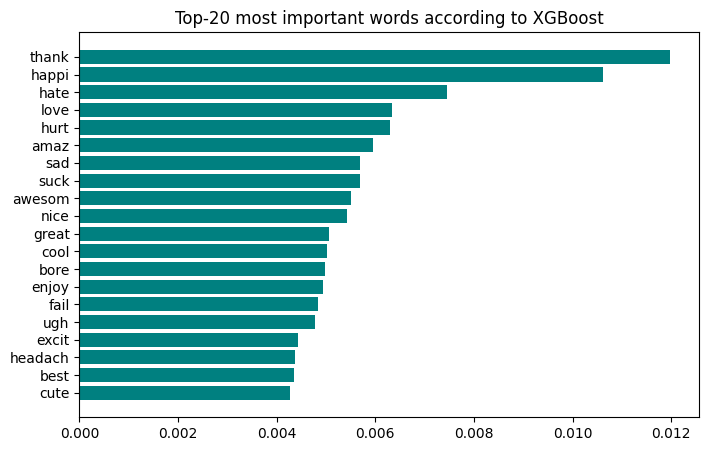

In [21]:
importance = best_model.feature_importances_

xgb_importance = pd.DataFrame({
    "word": vectorizer_bow.get_feature_names_out(),
    "importance": importance
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,5))
plt.barh(xgb_importance["word"], xgb_importance["importance"], color="teal")
plt.gca().invert_yaxis()
plt.title("Top-20 most important words according to XGBoost")
plt.show()

**In the positive class, words with clear positive sentiment dominate; in the negative class, typical negative markers appear; and in the neutral class, calm, emotion-free words prevail. This seems completely logical — the model is indeed capturing emotional vocabulary. The feature-importance analysis from XGBoost confirms that the same tokens contribute most strongly to the model’s decisions.**

### Text vectorization using TF-IDF

In [22]:
vectorizer_tfidf = TfidfVectorizer(max_features=5000)  
X_tfidf = vectorizer_tfidf.fit_transform(df["clean_text"])

X_tfidf.shape

(27480, 5000)

In [23]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
models_tfidf = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

results_tfidf = []

for name, model in models_tfidf.items():
    print(f"\n Model training (TF-IDF): {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results_tfidf.append((name, acc))
    print(f"Accuracy = {acc:.4f}")

results_tfidf_df = pd.DataFrame(results_tfidf, columns=["Model", "Accuracy"]).sort_values("Accuracy", ascending=False)
print("\n Comparing accuracy (TF-IDF):")
display(results_tfidf_df)


 Model training (TF-IDF): Logistic Regression
Accuracy = 0.6876

 Model training (TF-IDF): Decision Tree
Accuracy = 0.6436

 Model training (TF-IDF): Random Forest
Accuracy = 0.6963

 Model training (TF-IDF): XGBoost
Accuracy = 0.6872

 Comparing accuracy (TF-IDF):


,Model,Accuracy
2,Random Forest,0.696325
0,Logistic Regression,0.687591
3,XGBoost,0.687227
1,Decision Tree,0.643559


In [25]:
best_model_name_tfidf = results_tfidf_df.iloc[0, 0]
best_model_tfidf = models_tfidf[best_model_name_tfidf]

print(f"\n Best model (TF-IDF): {best_model_name_tfidf}\n")
y_pred_tfidf = best_model_tfidf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_tfidf, target_names=enc.categories_[0]))


 Best model (TF-IDF): Random Forest

              precision    recall  f1-score   support

    negative       0.72      0.62      0.67      1556
     neutral       0.65      0.72      0.68      2223
    positive       0.75      0.73      0.74      1717

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.70      5496
weighted avg       0.70      0.70      0.70      5496



In [26]:
train_test_results_tfidf = []

for name, model in models_tfidf.items():
    print(f"\n Model training (TF-IDF): {name}")
    model.fit(X_train_tfidf, y_train)

    y_pred_train = model.predict(X_train_tfidf)
    y_pred_test = model.predict(X_test_tfidf)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    train_test_results_tfidf.append((name, acc_train, acc_test))

train_test_df_tfidf = pd.DataFrame(train_test_results_tfidf, columns=["Model", "Train Accuracy", "Test Accuracy"])
train_test_df_tfidf["Diff"] = train_test_df_tfidf["Train Accuracy"] - train_test_df_tfidf["Test Accuracy"]

display(train_test_df_tfidf.sort_values("Diff", ascending=False))



 Model training (TF-IDF): Logistic Regression

 Model training (TF-IDF): Decision Tree

 Model training (TF-IDF): Random Forest

 Model training (TF-IDF): XGBoost


,Model,Train Accuracy,Test Accuracy,Diff
1,Decision Tree,0.992722,0.643559,0.349163
2,Random Forest,0.992722,0.696325,0.296397
0,Logistic Regression,0.775746,0.687591,0.088155
3,XGBoost,0.758597,0.687227,0.071370


In [27]:
log_reg_tfidf = LogisticRegression(max_iter=1000)
log_reg_tfidf.fit(X_train_tfidf, y_train)

feature_names_tfidf = np.array(vectorizer_tfidf.get_feature_names_out())
coeffs_tfidf = log_reg_tfidf.coef_

for i, class_label in enumerate(enc.categories_[0]):
    sorted_idx = np.argsort(coeffs_tfidf[i])
    top10 = feature_names_tfidf[sorted_idx[-10:]]
    bottom10 = feature_names_tfidf[sorted_idx[:10]]
    
    print(f"\n🔹 Most influential words for class '{class_label}' (TF-IDF):")
    print("  + Strong positive influence:", ", ".join(top10))
    print("  - Strong negative influence:", ", ".join(bottom10))


🔹 Most influential words for class 'negative' (TF-IDF):
  + Strong positive influence: tire, stupid, hurt, fail, bore, suck, hate, sorri, miss, sad
  - Strong negative influence: love, thank, awesom, hope, glad, great, nice, enjoy, cute, amaz

🔹 Most influential words for class 'neutral' (TF-IDF):
  + Strong positive influence: sent, werent, otherwis, jst, except, differ, moro, guitar, indoor, how
  - Strong negative influence: happi, good, fail, stupid, thank, nice, amaz, excit, funni, wtf

🔹 Most influential words for class 'positive' (TF-IDF):
  + Strong positive influence: enjoy, amaz, hope, happi, good, nice, great, awesom, thank, love
  - Strong negative influence: miss, sad, sorri, suck, tire, hate, bore, shame, bad, sick


**The Random Forest model achieved the highest accuracy, slightly outperforming the BoW results, although it is noticeably overfitted. TF-IDF helped reduce the weight of frequently used words and increased the influence of more meaningful tokens. The negative class is no longer confused with neutral tweets as often. Therefore, TF-IDF provides better generalization and accuracy with the same number of features, making it the preferable choice for the final implementation.**

### Error analysis of the classifier using TF-IDF vectorization

In [28]:
y_pred_tfidf = best_model_tfidf.predict(X_test_tfidf)


errors = X_test_tfidf.shape[0]
error_mask = (y_pred_tfidf != y_test)


errors_df = pd.DataFrame({
    "text": df.loc[y_test.index, "text"],  
    "true_label": enc.inverse_transform(y_test.values.reshape(-1, 1)).ravel(),
    "pred_label": enc.inverse_transform(y_pred_tfidf.reshape(-1, 1)).ravel()
})


errors_df = errors_df[errors_df["true_label"] != errors_df["pred_label"]]


errors_df.sample(10, random_state=42)

,text,true_label,pred_label
13633,time to go swimming in the freezing water at kalies. yeah!,positive,neutral
5129,6th street was amazing this weekend!!! The wedding was fantastic.. but im really really tired at work from the long eventful weekend,neutral,positive
6874,nice .. I can`t ever get that from my ex!,positive,negative
11304,Oh no adult school again,negative,neutral
18332,Fixed my favourites. $180 and the heels fell off after 4 wears,positive,neutral
4582,"dude, I can safely say I was blown away when I heard Attics. I`ll make sure I pass it on as much as I can!",positive,neutral
25588,"i thought ur account was fake. but, it`s true, sorry david!",neutral,negative
19653,aww... sorry for both of you. May the LORD give you strength and rest today!,neutral,negative
27417,ish okay my loveee,positive,neutral
2245,"I wish I was! well, for the past hour I have been. But before that I was in bed. Proper migraine!",negative,positive


<Figure size 500x400 with 0 Axes>

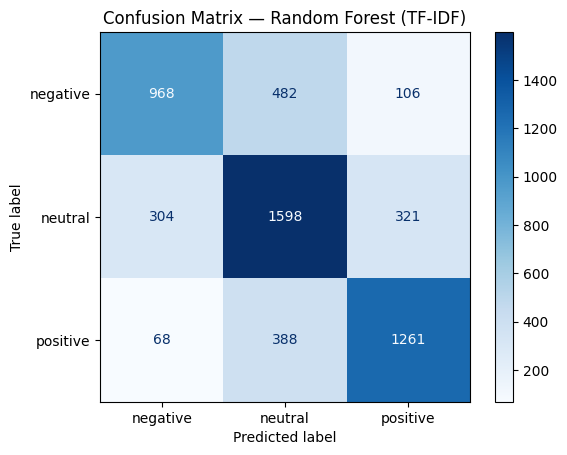

In [29]:
cm = confusion_matrix(y_test, y_pred_tfidf)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=enc.categories_[0]
)
plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Random Forest (TF-IDF)")
plt.show()

**The confusion matrix shows that the largest number of errors occurs between the negative and neutral classes (482 cases), and between the positive and neutral classes (388 cases). This indicates that the model struggles to distinguish messages with weak emotional coloring, where individual emotional words do not significantly change the overall tone of the text. At the same time, positive and negative tweets with clear emotional expression are recognized quite well. To improve classification quality, one could try using bigrams or trigrams in TF-IDF to better capture context; switch to more advanced models such as BERT; or apply lemmatization instead of stemming to preserve real word forms and improve feature quality.**